# All PREPARE

## IMPORT Data and libraries

In [20]:
import pandas as pd 
import numpy as np
from pathlib import Path
import openpyxl


In [21]:
docs_folder = Path(Path.cwd()/'docs')
data_upload = Path(docs_folder/ 'Выгрузка.xlsx')
data_plan = Path(docs_folder/ 'План.xlsx')
df_upload_raw = pd.read_excel(data_upload)

## PREPARE DATA 1 df_upload

In [22]:
df_upload_raw = pd.read_excel(data_upload,date_format=['Дата'])
df_upload_raw['Время начала (5-29)'] = pd.to_datetime(df_upload_raw['Время начала (5-29)'], format="%H:%M:%S").dt.time
df_upload_raw = df_upload_raw.rename(columns={
    'Ролик ID выхода'               :'ID_release',
    'Дата'                          :'date',
    'Время начала (5-29)'           :'time_begin',
    'Блок Распространение'          :'distribution_ch',
    'Ролик Тип'                     :'promo_video',
    "Ролик Ожидаемая длительность"  :'promo_video_duration',
    'Ролик Тип позиции в блоке'     :'promo_video_position',
    "Ролик ID"                      :'promo_video_ID',
    'Телекомпания'                  :'telecomp',
    "TVR All 25-55"                 :'TVR'

})
df_upload_raw[['promo_video_duration','TVR']] = df_upload_raw[['promo_video_duration','TVR']].apply(pd.to_numeric)
df_upload_raw['month'] = df_upload_raw.date.dt.month
# df_upload_raw.distribution_ch.value_counts()



## PREPARE DATA 2 data_plan

In [23]:
df_data_plan = pd.read_excel(data_plan)


In [24]:
def mapping_df(df_input):
    b_ind = df_data_plan.columns.get_loc('Бюджет')
    trp_ind = df_data_plan.columns.get_loc('TRP')-1

    bud = ['Бюджет' for i in range(trp_ind-b_ind+1)]
    trp = ['TRP' for i in range(trp_ind-b_ind+1)]
    df_data_plan.columns = df_data_plan.iloc[0,:]
    df_data_plan.drop(0,inplace=True)
    der = df_data_plan.T

    df_data_plan.index=df_data_plan.Телеканал
    new = df_data_plan.drop(columns='Телеканал').T
    # new['type'] = bud+trp

    new_1 = new.rename(columns={0:"month"})
    new_1 = new_1.apply(pd.to_numeric)
   
    df_plan, df_result = np.split(new_1, 2)
    return df_plan.T,df_result.T


In [25]:
# Split by Two DF: budjet and trp
df_budget,df_trp_raw= mapping_df(df_data_plan)

In [49]:
df_trp = df_trp_raw
df_trp.rename(columns={'Телеканал':'telecomp'})

month_rus   = ['Январь'	,'Февраль',	'Март','Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь']
month_numb  = list(range(1,13))

df_trp = df_trp.rename(columns=dict(zip(month_rus,month_numb))).reset_index()

In [27]:
# Группировка
df_group_upload= (
    df_upload_raw[['telecomp','TVR','month']]
    .groupby(['telecomp','month'])
    .agg(sum).reset_index()
    )
df_group_upload.head(7)

,telecomp,month,TVR
0,ПЕРВЫЙ КАНАЛ,1,53.7164
1,ПЕРВЫЙ КАНАЛ,3,59.0239
2,ПЕРВЫЙ КАНАЛ,5,57.9546
3,ПЕРВЫЙ КАНАЛ,7,50.7154
4,ПЕРВЫЙ КАНАЛ,9,52.7137
5,ПЕРВЫЙ КАНАЛ,11,46.6152
6,ПЯТНИЦА,1,157.3909


In [28]:
# Preparing
melted_df1 = pd.melt(df_trp, id_vars='Телеканал', var_name='month', value_name='plan')


melted_df1.rename(columns={'Телеканал': 'telecomp'}, inplace=True)
melted_df1['telecomp'] = melted_df1['telecomp'].str.upper()

melted_df1 = melted_df1.query('month !="Все месяцы"')

# Аналитика

## Tasks 1
 - [x] Задача: понять, выполняется ли в каждой кампании плановый объём TRP
    - general_rating рейтинг = 6
 - [x] Задача: по всем кампаниям
    - rating_each_company
    - rating_analog
    - [x] каналов дистрибъюции 1 == Сетевой : 3966
      - df_upload_raw.distribution_ch.value_counts()

In [47]:
def make_compare_df(group_by_value):
    df_compare=(
        pd.merge(melted_df1,df_group_upload,on=['telecomp','month'])
        .groupby(group_by_value).agg(
            plan=('plan','sum'),
            fact=('TVR','sum')).reset_index()
        )
    df_compare[['fact','plan']] = df_compare[['fact','plan']].apply(pd.to_numeric)
    df_compare['TVR_deviation'] = (df_compare['fact'] - df_compare['plan']) / df_compare['plan'] * 100


    return df_compare

df_compare=(
    pd.merge(melted_df1,df_group_upload,on=['telecomp','month'])
    .groupby(['telecomp']).agg(
        plan=('plan','sum'),
        fact=('TVR','sum')).reset_index()
    )

df_compare['TVR_deviation'] = (df_compare['fact'] - df_compare['plan']) / df_compare['plan'] * 100
categories = [-float('inf'),-10,-5,0,5,10, float('inf')]
ratings = [0, 2, 4, 6, 8,10]


df_compare['client_rating'] = pd.cut(df_compare['TVR_deviation'], bins=categories, labels=ratings)
customer_rating = df_compare[['telecomp','TVR_deviation']].rename(columns={'TVR_deviation':'customer_rating'})
rating_each_company= df_compare[['telecomp','client_rating']]
rating_each_company

,telecomp,client_rating
0,ПЯТНИЦА,8
1,РЕН ТВ,6
2,РОССИЯ 1,4
3,СТС,10
4,ТНТ,2


In [48]:
make_compare_df(group_by_value="month",total_row=False)
# def (df_compare):
    

,month,plan,fact,TVR_deviation
0,1,601.465287,702.6223,16.818429
1,3,601.465287,621.6417,3.354543
2,5,601.465287,639.7703,6.368616
3,7,601.465287,575.1045,-4.382761
4,9,575.871019,593.9412,3.137887
5,11,575.871019,559.7883,-2.792764


In [11]:

totals = df_compare.sum(numeric_only=True)

totals['telecomp'] = 'Итого'
df_compare = pd.concat([df_compare, pd.DataFrame(totals).T], ignore_index=True)    


df_compare[['fact','plan']] = df_compare[['fact','plan']].apply(pd.to_numeric)
df_compare['TVR_deviation'] = (df_compare['fact'] - df_compare['plan']) / df_compare['plan'] * 100
df_compare

categories = [-float('inf'),-10,-5,0,5,10, float('inf')]
ratings = [0, 2, 4, 6, 8,10]

df_compare = df_compare[['telecomp','plan','fact','TVR_deviation']]

df_compare['client_rating'] = pd.cut(df_compare['TVR_deviation'], bins=categories, labels=ratings)
df_compare
customer_rating = df_compare[['telecomp','client_rating']].rename(columns={'TVR_deviation':'customer_rating'})
general_rating = customer_rating.iloc[-1,:]

general_rating

telecomp         Итого
client_rating        6
Name: 5, dtype: object

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

## Графики 


<Axes: xlabel='month', ylabel='TVR_deviation'>

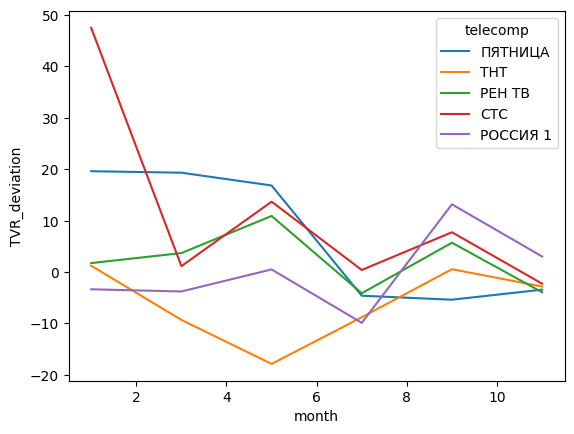

In [13]:
# telecomp	month	
df_compare_comp=(
    pd.merge(melted_df1,df_group_upload,on=['telecomp','month'])
    .groupby(['telecomp','month']).agg(
        plan=('plan','sum'),
        fact=('TVR','sum')).reset_index()
    )

df_compare_comp[['fact','plan']] = df_compare_comp[['fact','plan']].apply(pd.to_numeric)
df_compare_comp['TVR_deviation'] = (df_compare_comp['fact'] - df_compare_comp['plan']) / df_compare_comp['plan'] * 100
df = df_compare_comp[['telecomp','TVR_deviation','month','fact']]
df
sns.lineplot(data=df.sort_values(by='month'),x='month',y='TVR_deviation',hue='telecomp')


<Axes: xlabel='telecomp', ylabel='audience'>

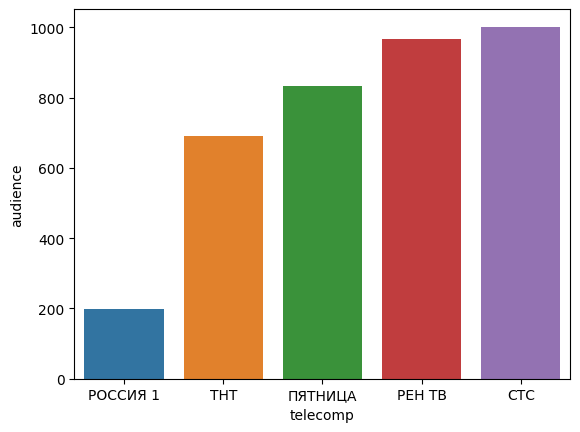

In [14]:
df.groupby('telecomp',as_index=False).agg(audience=("fact",'sum'))

sns.barplot(
    data=df.groupby('telecomp',as_index=False)
        .agg(audience=("fact",'sum'))
        .sort_values(by="audience"),
    y="audience",
    x="telecomp",
    )

# Рейтинг компаний друг относительно друга
## 1. quantile

In [15]:
# by every month quanilte
df = df_compare
q10 = df['TVR_deviation'].quantile(0.1)
q90 = df['TVR_deviation'].quantile(0.9)

df['rating_by_distribute'] = np.where(df['TVR_deviation'] < q10, 0, np.where(df['TVR_deviation'] > q90, 10, ((df['TVR_deviation'] - q10) / (q90 - q10)) * 10))

# Rounding ratings to nearest integer
df['rating_by_distribute'] = df['rating_by_distribute'].round().astype(int)
rating_analog = df[['telecomp',"TVR_deviation","client_rating",'rating_by_distribute']]
rating_analog

,telecomp,TVR_deviation,client_rating,rating_by_distribute
0,ПЯТНИЦА,7.219726,8,8
1,РЕН ТВ,2.345781,6,4
2,РОССИЯ 1,-0.177142,4,2
3,СТС,11.486599,10,10
4,ТНТ,-6.253938,2,0
5,Итого,3.802142,6,6
